In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
import matplotlib
import datetime
matplotlib.rcParams.update({'font.size': 22})
plt.rcParams['font.family']=['STFangsong']
starttime = datetime.datetime.now()
###########
#改變時間格式
###########
def Time_processing(d, t, ms):
    d = d.replace('/', '-')
    ds = d.split('-')
    d = ds[0] + '-' + ds[1].zfill(2) + '-' + ds[2].zfill(2)
    ts = t.split(':')
    t = ts[0].zfill(2) + ':' + ts[1].zfill(2) + ':' + ts[2].zfill(2)
    return d + ' ' + t + '.' + str(ms).zfill(3)


def Add_delta(df):
    xs = df['X軸機械座標'].values
    ys = df['Y軸機械座標'].values
    zs = df['Z軸機械座標'].values
    dx = np.zeros(len(xs))
    dy = np.zeros(len(ys))
    dz = np.zeros(len(zs))
    
    for i in range(1,len(xs)):
        dx[i] = np.abs(xs[i] - xs[i-1])
        dy[i] = np.abs(ys[i] - ys[i-1])
        dz[i] = np.abs(zs[i] - zs[i-1])
    df['dx'] = dx
    df['dy'] = dy
    df['dz'] = dz
    return df

###########
#獨進所有的plc.csv檔，並將其concate在一起成為一個dataframe 傳回
###########
def Read_plc(plc_dir):
    csv_files = os.listdir(plc_dir)
    df = pd.DataFrame()
    df_list = []
    for c in sorted(csv_files):
        if c[-4:] == '.csv': 
            print(c)
            df_ = pd.read_csv(plc_dir + c, encoding='big5')
            df_['file'] = c
            df_list.append(df_)
    df = pd.concat(df_list)
    df['time'] = np.vectorize(Time_processing)(df['日期'],df['時間'],df['毫秒'])
    df.drop(['日期','時間','毫秒'],axis=1, inplace=True)
    df['實際進給'] = pd.to_numeric(df['實際進給'], errors='coerce').fillna(0)
    df['實際轉速'] = pd.to_numeric(df['實際轉速'], errors='coerce').fillna(0)
    df['設定進給'] = pd.to_numeric(df['設定進給'], errors='coerce').fillna(0)
    df['設定轉速'] = pd.to_numeric(df['設定轉速'], errors='coerce').fillna(0)
    df['Z軸機械座標'] = df.apply(lambda x: round(x['Z軸機械座標'],4), axis=1)
    df = Add_delta(df)
    df.columns = ['prog', 'cut', 'set_feed', 'set_speed', 'loading', 'x', 'y', 'z',
       'cut_time', 'real_feed', 'real_speed', 'ratio', 'file', 'time', 'dx', 'dy', 'dz']
    
    print('Read_plc() finish!!!')
    print('time cost:', datetime.datetime.now()-starttime)
    return df


def Time_diff(x):
    t1 = datetime.datetime.strptime(x['time_begin'], '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000
    t2 = datetime.datetime.strptime(x['time_end'], '%Y-%m-%d %H:%M:%S.%f').timestamp() * 1000
    return t2 - t1
    
def Preprocess_df(plc_dir):
    plc_df = Read_plc(plc_dir)
    
    sql =("SELECT min(time) AS time_begin, max(time) AS time_end,"
                     "prog, loading, x, y, z,"
                     "real_feed, real_speed, set_feed, set_speed, file, ratio, "
                     "sum(dx) as dx , sum(dy) as dy, sum(dz) as dz "
                     "FROM plc_df "
                     "WHERE prog IS NOT NULL and real_feed>5000 and real_speed>1000 and set_feed==10000 and set_speed==2000 and ratio==100 "
                     " GROUP BY prog, loading, x, y, z, "
                     "         real_feed, real_speed, file "
                     "ORDER BY time_begin, time_end")
    data = sqldf(sql, locals())
    #data.reset_index(level=0, inplace=True)
    #data['index0'] = data.index
    data['dt'] = data.apply(Time_diff,axis=1)
    
    return data, plc_df


In [66]:
df, df_ori = Preprocess_df('/Users/Zion/Downloads/15-PLC/')

M03S00328070614.csv
M03S00328070615.csv


/Users/Zion/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


M03S00328070616.csv
M03S00328070708.csv
M03S00328070709.csv
M03S00328070710.csv
M03S00328070711.csv
M03S00328070714.csv
M03S00328070715.csv
Read_plc() finish!!!
time cost: 0:04:04.397186


In [67]:
df = df[df.prog.str.startswith('G')]
df['gcode'] = df.prog.str[1:2]
dummy = pd.get_dummies(df.gcode.values,prefix='G')
df['G_1'] = dummy['G_1'].values
df['G_2'] = dummy['G_2'].values
df['G_3'] = dummy['G_3'].values
df['dd'] = (df['dx']**2+df['dy']**2)**0.5

In [68]:
cols = ['real_feed', 'real_speed', 'dx', 'dy', 'dz', 'dd', 'dt', 'G_1', 'G_2', 'G_3', 'z']
#cols = ['real_feed', 'real_speed', 'dx', 'dy', 'dt', 'G_1', 'G_2', 'G_3']

df1 = df[cols]#, 'G_1', 'G_2', 'G_3']]
y = np.log1p(df['loading'])

In [69]:
from sklearn import preprocessing

x = df1.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

df2 = pd.DataFrame(x_scaled)
df2.columns = df1.columns


In [70]:
base_df = df2.iloc[:int(len(df2)/10)]
rest_df = df2.iloc[int(len(df2)/10):]
#base_df = df1.iloc[:int(len(df1)/10)]
#rest_df = df1.iloc[int(len(df1)/10):]

/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77:

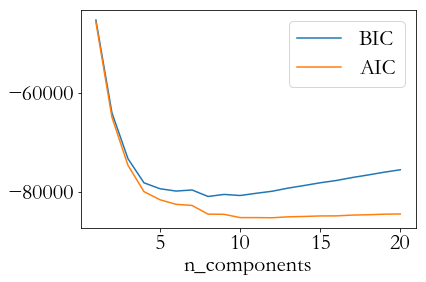

In [71]:
from sklearn.mixture import GMM
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(base_df) for n in n_components]

plt.plot(n_components, [m.bic(base_df) for m in models], label='BIC')
plt.plot(n_components, [m.aic(base_df) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [76]:
from sklearn.mixture import GMM
gmm = GMM(n_components=10).fit(base_df)
base_score = gmm.score_samples(base_df)[0]
rest_score = gmm.score_samples(rest_df)[0]


/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Zion/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77:

In [77]:
len(df1), len(base_score), len(rest_score)

(22987, 2298, 20689)

In [74]:
from sklearn.mixture import BayesianGaussianMixture

bgmm = BayesianGaussianMixture(n_components=8).fit(base_df)
 
base_score = bgmm.score_samples(base_df)
rest_score = bgmm.score_samples(rest_df)
base_label = bgmm.predict(base_df)
rest_label = bgmm.predict(rest_df)
base_prob = bgmm.predict_proba(base_df)
rest_prob = bgmm.predict_proba(rest_df)

In [75]:
base_score

array([28.98745889, 23.60979619, 23.40549142, ..., 20.99537696,
       24.03144577, 24.97553264])

In [42]:
for s in rest_score:
    print(s)

26.874069788537035
24.27664258971904
26.532955146943678
20.065239625630443
28.699774406776953
25.322668831295946
20.50703004239451
32.389095983796004
27.046225813838184
27.71784094393783
33.71629678734789
36.54899432204516
27.72024362944797
28.12590147390967
25.135896397304663
28.0112620991035
20.667993820713892
33.88117911114356
34.86590081005828
33.4852009422373
33.76816591037122
34.95245002078294
33.81362462589623
27.008599255484654
36.62732141572553
37.61206713267796
37.088102389594006
36.832777873023495
36.72956390330321
27.27734862965675
26.950839418792057
34.63724453966208
34.69427293472888
28.00829278314299
27.89204172639885
28.785640996602375
28.286689391919925
26.210338914654383
26.570861580737926
23.352039241592948
21.635724845301553
33.684902405915516
34.58997090738984
34.446899198444605
34.29119330426466
34.31271676981117
5.479767629212352
31.22536190856027
36.37548681348218
37.3655926771235
38.049193293403285
37.79569532377168
37.29807448002293
34.4229377898654
14.7151586

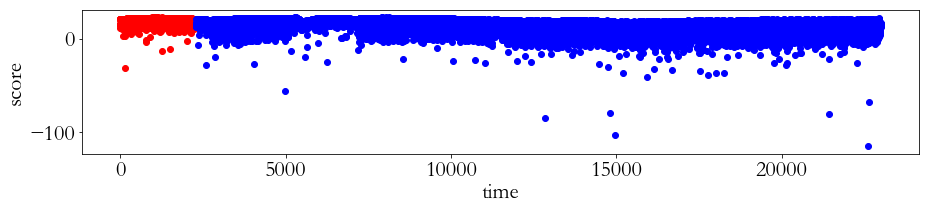

In [78]:
plt.figure(figsize=(15,9))
plt.subplot(3,1,1)
y1 = list(base_score)

#plt.plot(y1,c='g')
plt.scatter(range(len(y1)), y1,c='r', label='baseline data (first 1/10)')
#plt.legend(loc='best')

#plt.subplot(3,1,2)

y2 = list(rest_score)
#plt.plot(y1+y2,c='b')
#print(len(y1+y2))
plt.scatter(range(len(y1), len(y1)+len(y2)), y2,c='b', label='left data')
#plt.legend(loc='upperleft')
plt.xlabel('time')
plt.ylabel('score')
plt.show()

In [36]:
x = y1+y2
N = 10
means = np.convolve(x, np.ones((N,))/N, mode='valid')

In [37]:
means

array([ 29.83254891,  30.46519679,  31.8122484 , ..., -13.94461838,
        -8.01800426,  -3.01649567])

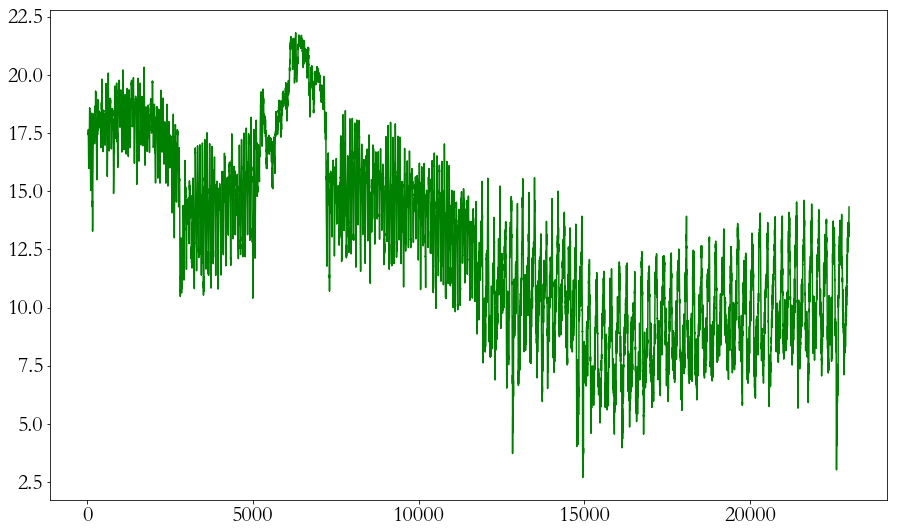

In [79]:
t_df = pd.DataFrame({'score':y1+y2})
#t_df.describe()
roll_mean = t_df.rolling(window=30).mean()
plt.figure(figsize=(15,9))
#y = list(t_df.score.values)
#y = means
y = list(roll_mean.values)
plt.plot(y,c='g')
plt.show()

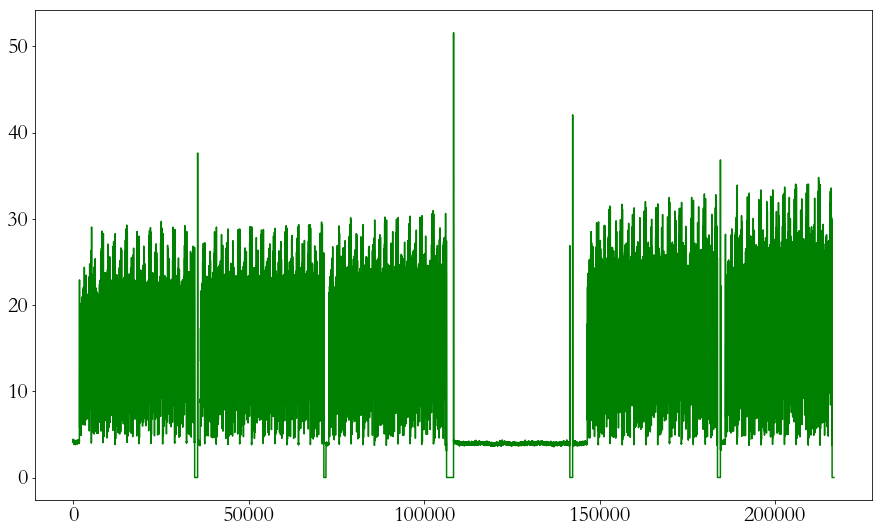

In [9]:
plt.figure(figsize=(15,9))

y1 = list(df_['主軸負載'].values)
plt.plot(y1,c='g')
plt.show()